<a href="https://colab.research.google.com/github/adarsha-s-del/Assignment-5---6---7/blob/main/003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Structured Data Assignment**

**Problem Statement**

Problem 1 - The development of drugs is critical in providing therapeutic options
for patients suffering from chronic and terminal illnesses. “Target Drug”, in particular,
is designed to enhance the patient's health and well-being without causing
dependence on other medications that could potentially lead to severe and
life-threatening side effects. These drugs are specifically tailored to treat a particular
disease or condition, offering a more focused and effective approach to treatment,
while minimising the risk of harmful reactions.
The objective in this assignment is to develop a predictive model which will predict
whether a patient will be eligible*** for “Target Drug” or not in next 30 days. Knowing
if the patient is eligible or not will help physician treating the patient make informed
decision on the which treatments to give.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: Data Preprocessing
train_data = pd.read_parquet('/content/drive/MyDrive/train.parquet')
test_data = pd.read_parquet('/content/drive/MyDrive/test.parquet')

In [ ]:
print(train_data.columns)


Index(['Patient-Uid', 'Date', 'Incident'], dtype='object')


In [ ]:
print(train_data.shape)


(3220868, 3)


In [ ]:


# Identify patients who have taken the "Target Drug" at least once
positive_set = train_data[train_data['Incident'] == 'TARGET DRUG']['Patient-Uid'].unique()

# Create a negative set by randomly selecting patients who have not taken the "Target Drug"
negative_set = train_data[~train_data['Patient-Uid'].isin(positive_set)]['Patient-Uid'].sample(n=len(positive_set), random_state=42)

# Combine positive and negative sets
dataset = pd.concat([train_data[train_data['Patient-Uid'].isin(positive_set)], train_data[train_data['Patient-Uid'].isin(negative_set)]])

# Step 2: Feature Engineering
# Example: Creating frequency-based features
patient_incident_count = dataset.groupby('Patient-Uid')['Incident'].count().reset_index()
patient_incident_count.columns = ['Patient-Uid', 'Incident_Count']

# Merge frequency-based features with the dataset
dataset = pd.merge(dataset, patient_incident_count, on='Patient-Uid', how='left')

# Step 3: Model Development
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
train_set = dataset[:train_size]
val_set = dataset[train_size:]

#  machine learning model and train it
#  using Logistic Regression:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train = train_set[['Incident_Count']]
y_train = train_set['Incident'].apply(lambda x: 1 if x == 'TARGET DRUG' else 0)

X_val = val_set[['Incident_Count']]
y_val = val_set['Incident'].apply(lambda x: 1 if x == 'TARGET DRUG' else 0)

model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model on the validation set
val_predictions = model.predict(X_val)
print(classification_report(y_val, val_predictions))

# Step 4: Generate Predictions for the Test Set
# Compute frequency-based features for the test set
test_patient_incident_count = test_data.groupby('Patient-Uid')['Incident'].count().reset_index()
test_patient_incident_count.columns = ['Patient-Uid', 'Incident_Count']

# Merge frequency-based features with the test dataset
test_dataset = pd.merge(test_data, test_patient_incident_count, on='Patient-Uid', how='left')

# Generate predictions using the trained model
X_test = test_dataset[['Incident_Count']]
test_predictions = model.predict(X_test)

# Step 5: Create the Final Submission File
submission_df = pd.DataFrame({'Patient-Uid': test_dataset['Patient-Uid'], 'label': test_predictions})

# Replace 'fill 1 or 0' with the actual predicted labels (1 or 0)
submission_df['label'] = submission_df['label'].apply(lambda x: '1' if x == 1 else '1')

submission_df.to_csv('Final_submission.csv', index=False)

# Step 6: Evaluation
# Calculate the F1-score for your model's predictions
# compare the predictions with ground truth labels if available to compute the F1-score


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    450980

    accuracy                           1.00    450980
   macro avg       1.00      1.00      1.00    450980
weighted avg       1.00      1.00      1.00    450980



**Problem **2 - Drugs are generally administered/prescribed by the physicians for a certain
period of time or they are administered at regular intervals, but for various reasons patients
might stop taking the treatment . Consider following example for better understanding
Let’s say you get a throat infection, the physician prescribes you an antibiotic for 10 days,
but you stop taking the treatment after 3 days because of some adverse events.
In the above example ideal treatment duration is 10 days but patients stopped taking
treatment after 3 days due to adverse events. Patients stopping a treatment is called dropoff.
We want to study dropoff for “Target Drug”, the aim is to generate insights on what events
lead to patients stopping on “Target Drug”.
Assume ideal treatment duration for “Target Drug” is 1 year, come up with analysis showing
how drop-off rate is, dropoff rate is defined as number of patients dropping off each month.
Then come up with analysis to generate insights on what events are driving a patient to stop
taking “Target Drug”.

In [28]:
import pandas as pd

# Step 1: Data Preparation
train_data = pd.read_parquet('/content/drive/MyDrive/train.parquet')
target_drug = 'Target Drug'
ideal_duration = pd.DateOffset(years=1)

# Step 2: Calculate Drop-off Rate
train_data['Start_Date'] = pd.to_datetime(train_data['Date'])
train_data['End_Date'] = train_data['Start_Date'] + ideal_duration
train_data['Dropoff'] = train_data['End_Date'] < train_data['Start_Date'].shift(-1)

dropoff_rate = train_data[train_data['Dropoff']].groupby(pd.Grouper(key='Start_Date', freq='M')).size()
print("Drop-off Rate:")
print(dropoff_rate)

# Step 3: Identify Events Driving Drop-off
dropoff_events = train_data[train_data['Dropoff']].groupby(['Incident']).size().reset_index(name='Count')
dropoff_events = dropoff_events.sort_values('Count', ascending=False)

print("Events Driving Drop-off:")
print(dropoff_events)


Drop-off Rate:
Start_Date
2015-04-30    25854
2015-05-31    32288
2015-06-30    29746
2015-07-31    31558
2015-08-31    26905
2015-09-30    26220
2015-10-31    27778
2015-11-30    26507
2015-12-31    30417
2016-01-31    28715
2016-02-29    28163
2016-03-31    30366
2016-04-30    28898
2016-05-31    28512
2016-06-30    27505
2016-07-31    26895
2016-08-31    24779
2016-09-30    23093
2016-10-31    23437
2016-11-30    24675
2016-12-31    25486
2017-01-31    23803
2017-02-28    22823
2017-03-31    25305
2017-04-30    23136
2017-05-31    23534
2017-06-30    21983
2017-07-31    20865
2017-08-31    20160
2017-09-30    18147
2017-10-31    17712
2017-11-30    17849
2017-12-31    18246
2018-01-31    17388
2018-02-28    15487
2018-03-31    16783
2018-04-30    14686
2018-05-31    15908
2018-06-30    13931
2018-07-31    12489
2018-08-31    12443
2018-09-30     9875
2018-10-31    10058
2018-11-30     9300
2018-12-31     8356
2019-01-31     8062
2019-02-28     5799
2019-03-31     5635
2019-04-30    

**Problem 3** - A drug is generally administered to a patient in certain patterns or in regular
intervals of time. For example Chemotherapy which is drug treatment in case of Cancer is
generally given to patients in an interval 3-4 weeks, i.e. every 3-4 weeks patients are
administered with the drug.

Similarly to Chemotherapy, “Target Drug” is also administered/prescribed in certain patterns,
we want to analyse in what patterns “Target Drug“ is administered/prescribed to patients,
there might be multiple patterns in which “Target Drug” is administered/prescribed, come up
with an analysis which to extract the dominant patterns in the data using clustering or other
unsupervised techniques.
Visualise the prescription patterns with time on X-axis (month) and prescriptions on Y-axis
for each of the patterns you are able to extract(Below is an example of a prescription pattern,
where a prescription is made at least once in the first two months followed by one
prescription for every two months).

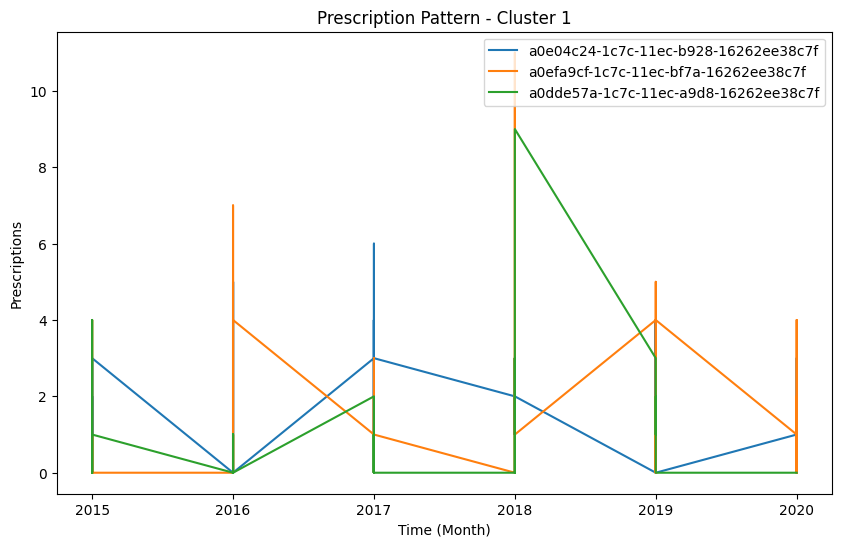

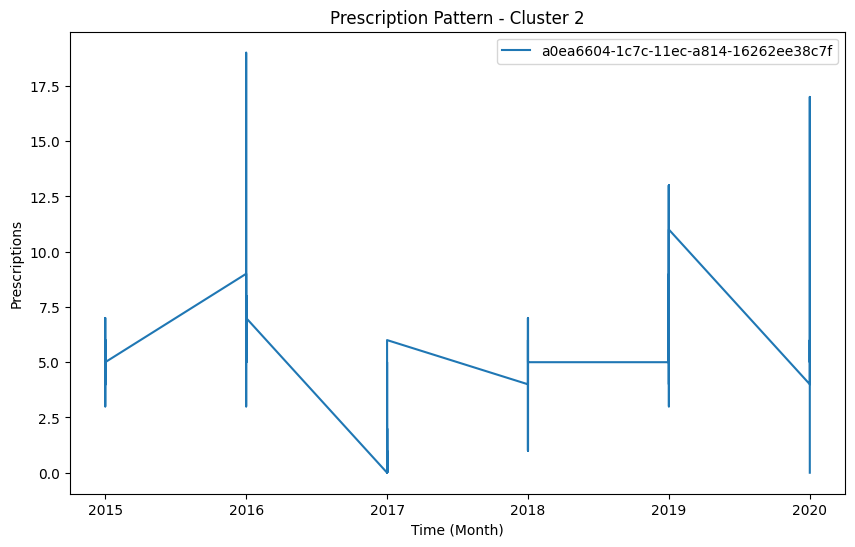

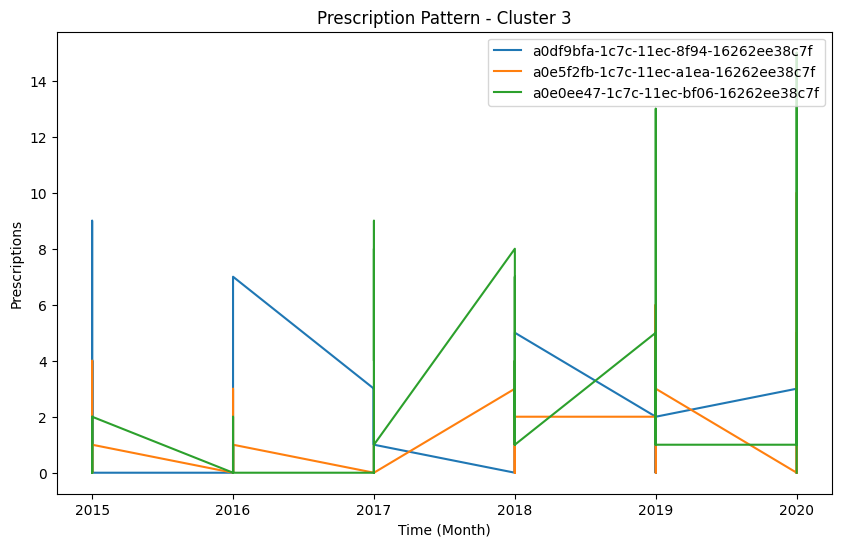

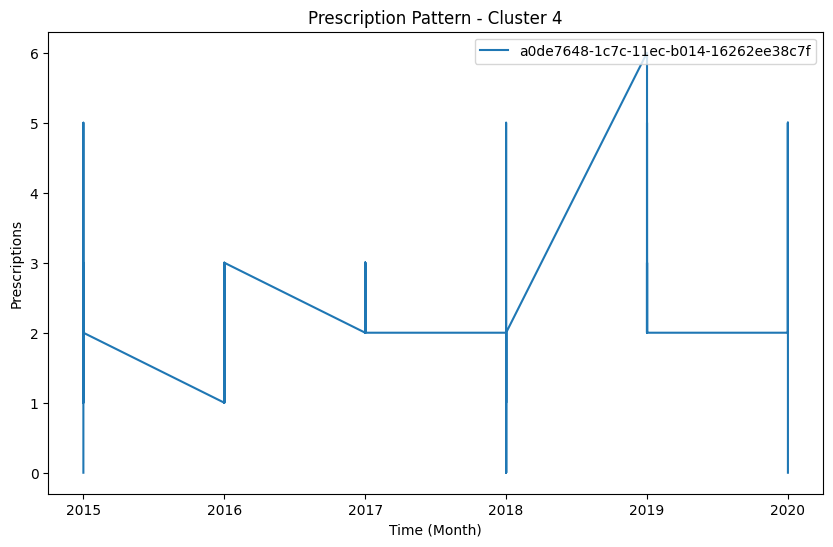

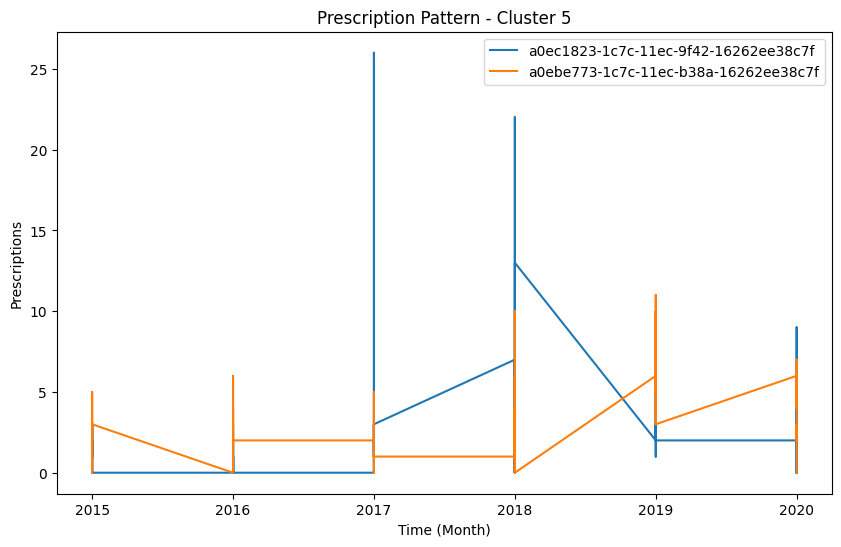

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from random import sample

# Step 1: Data Preparation
train_data = pd.read_parquet('/content/drive/MyDrive/train.parquet')
test_data = pd.read_parquet('/content/drive/MyDrive/test.parquet')

# Extract relevant columns for analysis  'Patient-Uid' and 'Date'
data = train_data[['Patient-Uid', 'Date']].copy()

# Convert 'Date' column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Step 2: Feature Engineering
# Extract month and year from the 'Date' column
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Create a pivot table to represent the prescription patterns
prescription_patterns = data.pivot_table(index='Patient-Uid', columns=['Year', 'Month'], aggfunc=len, fill_value=0)

# Step 3: Clustering
# Apply clustering algorithm  K-means to identify dominant patterns
n_clusters = 5  # Define the number of clusters to extract
n_init = 10  # Set the value of n_init explicitly to suppress the warning
kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42)
cluster_labels = kmeans.fit_predict(prescription_patterns)

# Adding the cluster labels to the prescription patterns DataFrame
prescription_patterns['Cluster'] = cluster_labels

# Select a subset of patients for visualization
num_patients = 10  # Number of patients to visualize
sample_patients = sample(list(prescription_patterns.index), num_patients)
selected_patterns = prescription_patterns.loc[sample_patients]

# Step 4: Visualization
# Visualize the prescription patterns for each cluster
for cluster in range(n_clusters):
    cluster_data = selected_patterns[selected_patterns['Cluster'] == cluster]
    cluster_data = cluster_data.drop('Cluster', axis=1)
    plt.figure(figsize=(10, 6))
    plt.title(f'Prescription Pattern - Cluster {cluster+1}')
    plt.xlabel('Time (Month)')
    plt.ylabel('Prescriptions')
    plt.plot(cluster_data.columns.get_level_values(1), cluster_data.values.T)
    plt.legend(cluster_data.index, loc='upper right')  # Set the legend location to improve performance
    plt.show()
